In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import os

from sklearn import cross_validation as cval
#from sklearn import utils
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import pickle

In [2]:
# Manipulated Variables
num_features = 10
selection_method = 'MIQ'
CV_test_number = 1
run_num = 1
output_filename = 'WindTurbine_fvsff_MIQ-' + str(num_features) + '_cv' + str(CV_test_number) + '-run' + str(run_num)

In [3]:
# Import training data
train_filename = '../Data/PickleFiles/3_labels_cv/training_data_cv' + str(CV_test_number) + '.p'
x_train = pd.read_pickle(train_filename)

train_filename = '../Data//PickleFiles/3_labels_cv/training_data_cv' + str(CV_test_number) + 'labelweights.p'
labelsweights = pd.read_pickle(train_filename)
x_train['__weight__'] = labelsweights['__weight__']
x_train['__label__'] = labelsweights['__label__']

# Shuffle the data
x_train = x_train.sample(frac=1, random_state=324351369)

# Remove out the labels, weights, and x_train data
y_train = x_train['__label__'].copy()
x_train_sample_weights = x_train['__weight__'].copy()
x_train.drop(['__label__', '__weight__'], 1, inplace=True)

# Import testing data
test_filename = '../Data/PickleFiles/3_labels_cv/testing_data_cv' + str(CV_test_number) +  '.p'
x_test = pd.read_pickle(test_filename)

test_filename = '../Data/PickleFiles/3_labels_cv/testing_data_cv' + str(CV_test_number) + 'labelweights.p'
labelsweights = pd.read_pickle(test_filename)
y_test = labelsweights['__label__'].copy()

del labelsweights

# Import the feature rankings
feature_filepath = '../Code-WindTurbine2/windturbine_fvsff_' + 'MIQ-first100.txt'
features = pd.read_csv(feature_filepath,  delimiter=' 	 ', header=2, engine='python')['Name']

In [4]:
print("train_filename is: \n%s\n" % train_filename)
print("test_filename is: \n%s\n" % test_filename)
print("output_filename is: \n%s\n" % output_filename)

train_filename is: 
../Data//PickleFiles/3_labels_cv/training_data_cv1labelweights.p

test_filename is: 
../Data/PickleFiles/3_labels_cv/testing_data_cv1labelweights.p

output_filename is: 
WindTurbine_fvsff_MIQ-10_cv1-run1



In [7]:
def CVTrainAndScore(X_train, y_train, X_test, y_test, weights, output_filename, search_type=RandomizedSearchCV,
    tuned_parameters={
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['auto', 1e-3, 1e-4],
        'C': [0.01, .1, 1, 10,  100, 1000]},
        #'class_weight':['balanced'],
        scores=['f1']):
    
    for score in scores:
        print("# Tuning hyper-parameters for %s \n" % score)

        # Find the hyperparameters
        clf = search_type(SVC(), tuned_parameters, fit_params={"sample_weight":weights}, cv=10, scoring='%s_weighted' % score, verbose=200)
        
        # Train the SVM
        clf.fit(X_train, y_train)

        print("\nBest parameters set found on development set: \n")
        print(clf.best_params_)

        print("\nGrid scores on development set:\n")
        for params, mean_score, scores in clf.grid_scores_:
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() * 2, params))

        print("\nDetailed classification report:\n")


        # Make the predictions on training set
        y_true, y_pred = y_train, clf.predict(X_train)
        print('Report on Training Set')
        print(classification_report(y_true, y_pred))
        print()
        # Evaluate the SVM using Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print(cm)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # Also print specificity metric
        print("Specificity:", cm[0, 0] / (cm[0, 1] + cm[0, 0]))

        # Make the predictions on the test set
        y_true, y_pred = y_test, clf.predict(X_test)
        print('Report on Test Set\n')
        print(classification_report(y_true, y_pred))
        print()
        # Evaluate the SVM using Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print(cm)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # Also print specificity metric
        print("Specificity:", cm[0, 0] / (cm[0, 1] + cm[0, 0]))
        
        # plot the confusion matrices
        plot = plot_confusion_matrix(cm_normalized)
        
        print(clf.best_params_)
        f=open(output_filename+score+'.p', 'wb')
        pickle.dump(clf, f)
        f.close()
        
        
def plot_confusion_matrix(cm):
    title='Confusion matrix',
    cmap=plt.cm.Blues
    labels=['No-Fault', 'Fault']
    
    plot = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Tuning hyper-parameters for f1 

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] gamma=auto, kernel=rbf, C=10 ....................................
[CV] ........... gamma=auto, kernel=rbf, C=10, score=0.996327 -   0.0s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.0s
[CV] gamma=auto, kernel=rbf, C=10 ....................................
[CV] ........... gamma=auto, kernel=rbf, C=10, score=0.997961 -   0.0s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:    0.1s
[CV] gamma=auto, kernel=rbf, C=10 ....................................
[CV] ........... gamma=auto, kernel=rbf, C=10, score=0.994839 -   0.0s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:    0.1s
[CV] gamma=auto, kernel=rbf, C=10 ....................................
[CV] ........... gamma=auto, kernel=rbf, C=10, score=0.997956 -   0.0s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.2s
[CV] gamma=auto, kernel=rbf, C=10 ....................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


[CV] ........... gamma=auto, kernel=rbf, C=10, score=0.997956 -   0.0s
[Parallel(n_jobs=1)]: Done   5 tasks       | elapsed:    0.2s
[CV] gamma=auto, kernel=rbf, C=10 ....................................
[CV] ........... gamma=auto, kernel=rbf, C=10, score=1.000000 -   0.0s
[Parallel(n_jobs=1)]: Done   6 tasks       | elapsed:    0.2s
[CV] gamma=auto, kernel=rbf, C=10 ....................................
[CV] ........... gamma=auto, kernel=rbf, C=10, score=0.996301 -   0.0s
[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    0.3s
[CV] gamma=auto, kernel=rbf, C=10 ....................................
[CV] ........... gamma=auto, kernel=rbf, C=10, score=0.996301 -   0.0s
[Parallel(n_jobs=1)]: Done   8 tasks       | elapsed:    0.3s
[CV] gamma=auto, kernel=rbf, C=10 ....................................
[CV] ........... gamma=auto, kernel=rbf, C=10, score=1.000000 -   0.0s
[Parallel(n_jobs=1)]: Done   9 tasks       | elapsed:    0.4s
[CV] gamma=auto, kernel=rbf, C=10 .................

/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........ gamma=auto, kernel=sigmoid, C=1, score=0.996334 -   0.5s
[Parallel(n_jobs=1)]: Done  11 tasks       | elapsed:    0.9s
[CV] gamma=auto, kernel=sigmoid, C=1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........ gamma=auto, kernel=sigmoid, C=1, score=0.996334 -   0.5s
[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:    1.5s
[CV] gamma=auto, kernel=sigmoid, C=1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........ gamma=auto, kernel=sigmoid, C=1, score=0.996325 -   0.5s
[Parallel(n_jobs=1)]: Done  13 tasks       | elapsed:    2.0s
[CV] gamma=auto, kernel=sigmoid, C=1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........ gamma=auto, kernel=sigmoid, C=1, score=0.996325 -   0.5s
[Parallel(n_jobs=1)]: Done  14 tasks       | elapsed:    2.6s
[CV] gamma=auto, kernel=sigmoid, C=1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........ gamma=auto, kernel=sigmoid, C=1, score=0.996325 -   0.5s
[Parallel(n_jobs=1)]: Done  15 tasks       | elapsed:    3.1s
[CV] gamma=auto, kernel=sigmoid, C=1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........ gamma=auto, kernel=sigmoid, C=1, score=0.996325 -   0.5s
[Parallel(n_jobs=1)]: Done  16 tasks       | elapsed:    3.6s
[CV] gamma=auto, kernel=sigmoid, C=1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ........ gamma=auto, kernel=sigmoid, C=1, score=0.000000 -   0.6s
[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:    4.2s
[CV] gamma=auto, kernel=sigmoid, C=1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ........ gamma=auto, kernel=sigmoid, C=1, score=0.000000 -   0.6s
[Parallel(n_jobs=1)]: Done  18 tasks       | elapsed:    4.7s
[CV] gamma=auto, kernel=sigmoid, C=1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ........ gamma=auto, kernel=sigmoid, C=1, score=0.000000 -   0.6s
[Parallel(n_jobs=1)]: Done  19 tasks       | elapsed:    5.3s
[CV] gamma=auto, kernel=sigmoid, C=1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ........ gamma=auto, kernel=sigmoid, C=1, score=0.000000 -   0.6s
[Parallel(n_jobs=1)]: Done  20 tasks       | elapsed:    5.8s
[CV] gamma=0.001, kernel=rbf, C=0.1 ..................................
[CV] ......... gamma=0.001, kernel=rbf, C=0.1, score=0.520482 -   1.0s
[Parallel(n_jobs=1)]: Done  21 tasks       | elapsed:    6.9s
[CV] gamma=0.001, kernel=rbf, C=0.1 ..................................
[CV] ......... gamma=0.001, kernel=rbf, C=0.1, score=0.520482 -   1.0s
[Parallel(n_jobs=1)]: Done  22 tasks       | elapsed:    7.9s
[CV] gamma=0.001, kernel=rbf, C=0.1 ..................................
[CV] ......... gamma=0.001, kernel=rbf, C=0.1, score=0.529404 -   1.0s
[Parallel(n_jobs=1)]: Done  23 tasks       | elapsed:    8.9s
[CV] gamma=0.001, kernel=rbf, C=0.1 ..................................
[CV] ......... gamma=0.001, kernel=rbf, C=0.1, score=0.474507 -   1.0s
[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:    9.9s
[CV] gamma=0.001, kernel=rbf, C=0.1 ...............

/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ......... gamma=0.001, kernel=rbf, C=0.1, score=0.511883 -   1.0s
[Parallel(n_jobs=1)]: Done  27 tasks       | elapsed:   13.0s
[CV] gamma=0.001, kernel=rbf, C=0.1 ..................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ......... gamma=0.001, kernel=rbf, C=0.1, score=0.492593 -   0.9s
[Parallel(n_jobs=1)]: Done  28 tasks       | elapsed:   13.9s
[CV] gamma=0.001, kernel=rbf, C=0.1 ..................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ......... gamma=0.001, kernel=rbf, C=0.1, score=0.530686 -   1.0s
[Parallel(n_jobs=1)]: Done  29 tasks       | elapsed:   14.9s
[CV] gamma=0.001, kernel=rbf, C=0.1 ..................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ......... gamma=0.001, kernel=rbf, C=0.1, score=0.535971 -   1.0s
[Parallel(n_jobs=1)]: Done  30 tasks       | elapsed:   15.9s
[CV] gamma=0.001, kernel=linear, C=1000 ..............................
[CV] ..... gamma=0.001, kernel=linear, C=1000, score=0.994852 -   0.2s
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   16.0s
[CV] gamma=0.001, kernel=linear, C=1000 ..............................
[CV] ..... gamma=0.001, kernel=linear, C=1000, score=0.993456 -   0.1s
[Parallel(n_jobs=1)]: Done  32 tasks       | elapsed:   16.2s
[CV] gamma=0.001, kernel=linear, C=1000 ..............................
[CV] ..... gamma=0.001, kernel=linear, C=1000, score=0.996317 -   0.1s
[Parallel(n_jobs=1)]: Done  33 tasks       | elapsed:   16.3s
[CV] gamma=0.001, kernel=linear, C=1000 ..............................
[CV] ..... gamma=0.001, kernel=linear, C=1000, score=0.993440 -   0.1s
[Parallel(n_jobs=1)]: Done  34 tasks       | elapsed:   16.5s
[CV] gamma=0.001, kernel=linear, C=1000 ...........

/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ..... gamma=0.001, kernel=linear, C=1000, score=0.992574 -   0.2s
[Parallel(n_jobs=1)]: Done  38 tasks       | elapsed:   17.1s
[CV] gamma=0.001, kernel=linear, C=1000 ..............................
[CV] ..... gamma=0.001, kernel=linear, C=1000, score=0.995062 -   0.1s
[Parallel(n_jobs=1)]: Done  39 tasks       | elapsed:   17.3s
[CV] gamma=0.001, kernel=linear, C=1000 ..............................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ..... gamma=0.001, kernel=linear, C=1000, score=0.992574 -   0.1s
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:   17.4s
[CV] gamma=0.001, kernel=sigmoid, C=100 ..............................
[CV] ..... gamma=0.001, kernel=sigmoid, C=100, score=0.980447 -   0.1s
[Parallel(n_jobs=1)]: Done  41 tasks       | elapsed:   17.5s
[CV] gamma=0.001, kernel=sigmoid, C=100 ..............................
[CV] ..... gamma=0.001, kernel=sigmoid, C=100, score=0.985586 -   0.1s
[Parallel(n_jobs=1)]: Done  42 tasks       | elapsed:   17.6s
[CV] gamma=0.001, kernel=sigmoid, C=100 ..............................
[CV] ..... gamma=0.001, kernel=sigmoid, C=100, score=0.984261 -   0.1s
[Parallel(n_jobs=1)]: Done  43 tasks       | elapsed:   17.8s
[CV] gamma=0.001, kernel=sigmoid, C=100 ..............................
[CV] ..... gamma=0.001, kernel=sigmoid, C=100, score=0.985550 -   0.1s
[Parallel(n_jobs=1)]: Done  44 tasks       | elapsed:   17.9s
[CV] gamma=0.001, kernel=sigmoid, C=100 ...........

/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ..... gamma=0.001, kernel=sigmoid, C=100, score=0.973518 -   0.1s
[Parallel(n_jobs=1)]: Done  48 tasks       | elapsed:   18.4s
[CV] gamma=0.001, kernel=sigmoid, C=100 ..............................
[CV] ..... gamma=0.001, kernel=sigmoid, C=100, score=0.985037 -   0.1s
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   18.5s
[CV] gamma=0.001, kernel=sigmoid, C=100 ..............................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ..... gamma=0.001, kernel=sigmoid, C=100, score=0.976101 -   0.1s
[Parallel(n_jobs=1)]: Done  50 tasks       | elapsed:   18.6s
[CV] gamma=0.0001, kernel=rbf, C=0.1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=0.1, score=0.996334 -   1.0s
[Parallel(n_jobs=1)]: Done  51 tasks       | elapsed:   19.7s
[CV] gamma=0.0001, kernel=rbf, C=0.1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=0.1, score=0.996334 -   1.0s
[Parallel(n_jobs=1)]: Done  52 tasks       | elapsed:   20.7s
[CV] gamma=0.0001, kernel=rbf, C=0.1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=0.1, score=0.996325 -   1.0s
[Parallel(n_jobs=1)]: Done  53 tasks       | elapsed:   21.8s
[CV] gamma=0.0001, kernel=rbf, C=0.1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=0.1, score=0.996325 -   1.0s
[Parallel(n_jobs=1)]: Done  54 tasks       | elapsed:   22.8s
[CV] gamma=0.0001, kernel=rbf, C=0.1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=0.1, score=0.996325 -   1.0s
[Parallel(n_jobs=1)]: Done  55 tasks       | elapsed:   23.8s
[CV] gamma=0.0001, kernel=rbf, C=0.1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=0.1, score=0.996325 -   1.0s
[Parallel(n_jobs=1)]: Done  56 tasks       | elapsed:   24.9s
[CV] gamma=0.0001, kernel=rbf, C=0.1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=0.1, score=0.000000 -   1.1s
[Parallel(n_jobs=1)]: Done  57 tasks       | elapsed:   26.0s
[CV] gamma=0.0001, kernel=rbf, C=0.1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=0.1, score=0.000000 -   1.1s
[Parallel(n_jobs=1)]: Done  58 tasks       | elapsed:   27.1s
[CV] gamma=0.0001, kernel=rbf, C=0.1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=0.1, score=0.000000 -   1.1s
[Parallel(n_jobs=1)]: Done  59 tasks       | elapsed:   28.2s
[CV] gamma=0.0001, kernel=rbf, C=0.1 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=0.1, score=0.000000 -   1.1s
[Parallel(n_jobs=1)]: Done  60 tasks       | elapsed:   29.3s
[CV] gamma=0.001, kernel=linear, C=10 ................................
[CV] ....... gamma=0.001, kernel=linear, C=10, score=0.992103 -   0.0s
[Parallel(n_jobs=1)]: Done  61 tasks       | elapsed:   29.4s
[CV] gamma=0.001, kernel=linear, C=10 ................................
[CV] ....... gamma=0.001, kernel=linear, C=10, score=0.993456 -   0.0s
[Parallel(n_jobs=1)]: Done  62 tasks       | elapsed:   29.4s
[CV] gamma=0.001, kernel=linear, C=10 ................................
[CV] ....... gamma=0.001, kernel=linear, C=10, score=0.996317 -   0.0s
[Parallel(n_jobs=1)]: Done  63 tasks       | elapsed:   29.5s
[CV] gamma=0.001, kernel=linear, C=10 ................................
[CV] ....... gamma=0.001, kernel=linear, C=10, score=0.990754 -   0.0s
[Parallel(n_jobs=1)]: Done  64 tasks       | elapsed:   29.5s
[CV] gamma=0.001, kernel=linear, C=10 .............

/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ....... gamma=0.001, kernel=linear, C=10, score=0.991326 -   0.0s
[Parallel(n_jobs=1)]: Done  68 tasks       | elapsed:   29.7s
[CV] gamma=0.001, kernel=linear, C=10 ................................
[CV] ....... gamma=0.001, kernel=linear, C=10, score=0.995062 -   0.0s
[Parallel(n_jobs=1)]: Done  69 tasks       | elapsed:   29.8s
[CV] gamma=0.001, kernel=linear, C=10 ................................
[CV] ....... gamma=0.001, kernel=linear, C=10, score=0.992574 -   0.0s
[Parallel(n_jobs=1)]: Done  70 tasks       | elapsed:   29.8s
[CV] gamma=0.001, kernel=rbf, C=100 ..................................
[CV] ......... gamma=0.001, kernel=rbf, C=100, score=0.980447 -   0.1s
[Parallel(n_jobs=1)]: Done  71 tasks       | elapsed:   29.9s
[CV] gamma=0.001, kernel=rbf, C=100 ..................................
[CV] ......... gamma=0.001, kernel=rbf, C=100, score=0.988167 -   0.1s
[Parallel(n_jobs=1)]: Done  72 tasks       | elapsed:   30.0s
[CV] gamma=0.001, kernel=rbf, C=100 ...............

/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ......... gamma=0.001, kernel=rbf, C=100, score=0.985037 -   0.1s
[Parallel(n_jobs=1)]: Done  77 tasks       | elapsed:   30.5s
[CV] gamma=0.001, kernel=rbf, C=100 ..................................
[CV] ......... gamma=0.001, kernel=rbf, C=100, score=0.978670 -   0.1s
[Parallel(n_jobs=1)]: Done  78 tasks       | elapsed:   30.6s
[CV] gamma=0.001, kernel=rbf, C=100 ..................................
[CV] ......... gamma=0.001, kernel=rbf, C=100, score=0.991326 -   0.1s
[Parallel(n_jobs=1)]: Done  79 tasks       | elapsed:   30.7s
[CV] gamma=0.001, kernel=rbf, C=100 ..................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ......... gamma=0.001, kernel=rbf, C=100, score=0.985037 -   0.1s
[Parallel(n_jobs=1)]: Done  80 tasks       | elapsed:   30.8s
[CV] gamma=0.0001, kernel=sigmoid, C=10 ..............................
[CV] ..... gamma=0.0001, kernel=sigmoid, C=10, score=0.869290 -   0.7s
[Parallel(n_jobs=1)]: Done  81 tasks       | elapsed:   31.5s
[CV] gamma=0.0001, kernel=sigmoid, C=10 ..............................
[CV] ..... gamma=0.0001, kernel=sigmoid, C=10, score=0.877026 -   0.7s
[Parallel(n_jobs=1)]: Done  82 tasks       | elapsed:   32.2s
[CV] gamma=0.0001, kernel=sigmoid, C=10 ..............................
[CV] ..... gamma=0.0001, kernel=sigmoid, C=10, score=0.875145 -   0.7s
[Parallel(n_jobs=1)]: Done  83 tasks       | elapsed:   32.9s
[CV] gamma=0.0001, kernel=sigmoid, C=10 ..............................
[CV] ..... gamma=0.0001, kernel=sigmoid, C=10, score=0.861062 -   0.7s
[Parallel(n_jobs=1)]: Done  84 tasks       | elapsed:   33.6s
[CV] gamma=0.0001, kernel=sigmoid, C=10 ...........

/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ..... gamma=0.0001, kernel=sigmoid, C=10, score=0.874136 -   0.7s
[Parallel(n_jobs=1)]: Done  87 tasks       | elapsed:   35.7s
[CV] gamma=0.0001, kernel=sigmoid, C=10 ..............................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ..... gamma=0.0001, kernel=sigmoid, C=10, score=0.858345 -   0.7s
[Parallel(n_jobs=1)]: Done  88 tasks       | elapsed:   36.5s
[CV] gamma=0.0001, kernel=sigmoid, C=10 ..............................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ..... gamma=0.0001, kernel=sigmoid, C=10, score=0.858345 -   0.7s
[Parallel(n_jobs=1)]: Done  89 tasks       | elapsed:   37.2s
[CV] gamma=0.0001, kernel=sigmoid, C=10 ..............................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ..... gamma=0.0001, kernel=sigmoid, C=10, score=0.886457 -   0.7s
[Parallel(n_jobs=1)]: Done  90 tasks       | elapsed:   37.9s
[CV] gamma=0.0001, kernel=rbf, C=100 .................................
[CV] ........ gamma=0.0001, kernel=rbf, C=100, score=0.967514 -   0.2s
[Parallel(n_jobs=1)]: Done  91 tasks       | elapsed:   38.1s
[CV] gamma=0.0001, kernel=rbf, C=100 .................................
[CV] ........ gamma=0.0001, kernel=rbf, C=100, score=0.972713 -   0.2s
[Parallel(n_jobs=1)]: Done  92 tasks       | elapsed:   38.3s
[CV] gamma=0.0001, kernel=rbf, C=100 .................................
[CV] ........ gamma=0.0001, kernel=rbf, C=100, score=0.967432 -   0.2s
[Parallel(n_jobs=1)]: Done  93 tasks       | elapsed:   38.5s
[CV] gamma=0.0001, kernel=rbf, C=100 .................................
[CV] ........ gamma=0.0001, kernel=rbf, C=100, score=0.972645 -   0.2s
[Parallel(n_jobs=1)]: Done  94 tasks       | elapsed:   38.7s
[CV] gamma=0.0001, kernel=rbf, C=100 ..............

/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=100, score=0.964377 -   0.2s
[Parallel(n_jobs=1)]: Done  97 tasks       | elapsed:   39.3s
[CV] gamma=0.0001, kernel=rbf, C=100 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=100, score=0.961735 -   0.2s
[Parallel(n_jobs=1)]: Done  98 tasks       | elapsed:   39.5s
[CV] gamma=0.0001, kernel=rbf, C=100 .................................
[CV] ........ gamma=0.0001, kernel=rbf, C=100, score=0.968314 -   0.2s
[Parallel(n_jobs=1)]: Done  99 tasks       | elapsed:   39.7s
[CV] gamma=0.0001, kernel=rbf, C=100 .................................


/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lhu/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV] ........ gamma=0.0001, kernel=rbf, C=100, score=0.964377 -   0.2s
[Parallel(n_jobs=1)]: Done 100 tasks       | elapsed:   40.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   40.0s finished

Best parameters set found on development set: 

{'gamma': 'auto', 'kernel': 'rbf', 'C': 10}

Grid scores on development set:

0.997 (+/-0.004) for {'gamma': 'auto', 'kernel': 'rbf', 'C': 10}
0.599 (+/-0.976) for {'gamma': 'auto', 'kernel': 'sigmoid', 'C': 1}
0.512 (+/-0.036) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 0.1}
0.995 (+/-0.003) for {'gamma': 0.001, 'kernel': 'linear', 'C': 1000}
0.982 (+/-0.008) for {'gamma': 0.001, 'kernel': 'sigmoid', 'C': 100}
0.599 (+/-0.976) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 0.1}
0.994 (+/-0.004) for {'gamma': 0.001, 'kernel': 'linear', 'C': 10}
0.985 (+/-0.007) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 100}
0.873 (+/-0.021) for {'gamma': 0.0001, 'kernel': 'sigmoid', 'C': 10}
0.967 (+/-0.008) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 100}



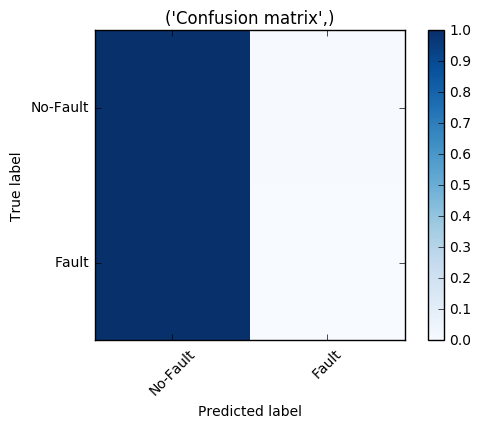

{'gamma': 'auto', 'kernel': 'rbf', 'C': 10}


In [8]:
x_train = x_train.loc[:, features[0:num_features]]
x_test = x_test.loc[:, features[0:num_features]]
CVTrainAndScore(x_train, y_train, x_test, y_test, x_train_sample_weights, output_filename=output_filename)

In [21]:
x_train.columns

Index(['Diff_P_technical_P_majeure_mean', 'Dif_rotor_1_avg_temps_t-4',
       'CS101__Rear_bearing_temp_std', 'Diff_Avg_Sys_2_inverter_4_t-6',
       'Diff_P_technical_P_external_std', 'CS101__Ambient_temp_mean',
       'Diff_P_technical_P_external_mean', 'CS101__Control_cabinet_temp_std',
       'Diff_Avg_Sys_1_inverter_6_std', 'Dif_max_avg_rotation_std'],
      dtype='object')